This notebook sets up the workflow for the various functions we have implemented. It shows an example of how we clustered using Nonnegative Matrix Factorization. We manually inspect the output of NMF to determine the best number of clusters for each group

In [1]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from utils.clean_up import *
from utils.categorize_demographics import *
from utils.nonnegative_matrix_factorization import nmf_inspect, nmf_labels

warnings.filterwarnings('ignore')
%matplotlib inline

/Users/JS/.virtualenvs/test/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
mpl.rc('savefig', dpi=200)
params = {'figure.dpi' : 200,
          'figure.figsize' : (16, 12),
          'axes.axisbelow' : True,
          'lines.antialiased' : True,
          'axes.titlesize' : 'xx-large',
          'axes.labelsize' : 'x-large',
          'xtick.labelsize' : 'large',
          'ytick.labelsize' : 'large',
          'legend.fontsize' : 'x-large',
          'savefig.transparent' : True}

for (k, v) in params.items():
    plt.rcParams[k] = v

In [3]:
essay_dict = {'essay0' : 'My self summary',
              'essay1' : 'What I\'m doing with my life',
              'essay2' : 'I\'m really good at',
              'essay3' : 'The first thing people notice about me',
              'essay4' : 'Favorite books, movies, tv, food',
              'essay5' : 'The six things I could never do without',
              'essay6' : 'I spend a lot of time thinking about',
              'essay7' : 'On a typical Friday night I am',
              'essay8' : 'The most private thing I am willing to admit',
              'essay9' : 'You should message me if'}

Getting the data, cleaning it, and categorizing demographic data

In [4]:
df = pd.read_csv('data/profiles.20120630.csv')

In [5]:
essay_list = ['essay4']
df_clean = clean_up(df, essay_list)

In [6]:
df_clean.shape

(48105, 32)

In [7]:
df_clean.fillna('', inplace=True)

In [8]:
df_clean['religion'] = df_clean['religion'].apply(religion_categories)
df_clean['job'] = df_clean['job'].apply(job_categories)
df_clean['drugs'] = df_clean['drugs'].apply(drug_categories)
df_clean['diet'] = df_clean['diet'].apply(diet_categories)
df_clean['body_type'] = df_clean['body_type'].apply(body_categories)
df_clean['drinks'] = df_clean['drinks'].apply(drink_categories)
df_clean['sign'] = df_clean['sign'].apply(sign_categories)
df_clean['ethnicity'] = df_clean['ethnicity'].apply(ethnicity_categories)
df_clean['pets'] = df_clean['pets'].apply(pets_categories)
df_clean['speaks'] = df_clean['speaks'].apply(language_categories)

In [9]:
count_matrix, tfidf_matrix, vocab = col_to_data_matrix(df_clean, essay_list[0])

In [10]:
K = 25

In [11]:
nmf_inspect(tfidf_matrix, vocab, k_vals=[K], n_words=50)

25
Group 0:
like | music like | movies like | really like | really | stuff | things | food like | don't like | like music | like kinds | books like | like movies | kinds | like food | like read | like lot | stuff like | movies | lot | different | comedies | kind | music | especially | think | don't | ... like | people | kinds music | make | foods | feel | bands | action | probably | fiction | lots | tend | funny | eat | ones | try | classics | novels | cook | old | type | going | variety

Group 1:
men | mad | mad men | arrested | development | arrested development | bad | breaking | breaking bad | tv | sunny | 30 | 30 rock | parks | wire | shows | dexter | it's sunny | sunny philadelphia | philadelphia | it's | curb | office | curb enthusiasm | enthusiasm | it's sunny philadelphia | rec | parks rec | community | recreation | parks recreation | seinfeld | tv shows | daily | archer | rock | weeds | louie | colbert | lost | walking | walking dead | blood | feet | californication | report 

In [12]:
df_clean['group'] = nmf_labels(tfidf_matrix, k=K)

In [13]:
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821',
          '#D55E00', '#CC79A7', '#56B4E9', '#009E73',
          '#F0E442', '#0072B2']

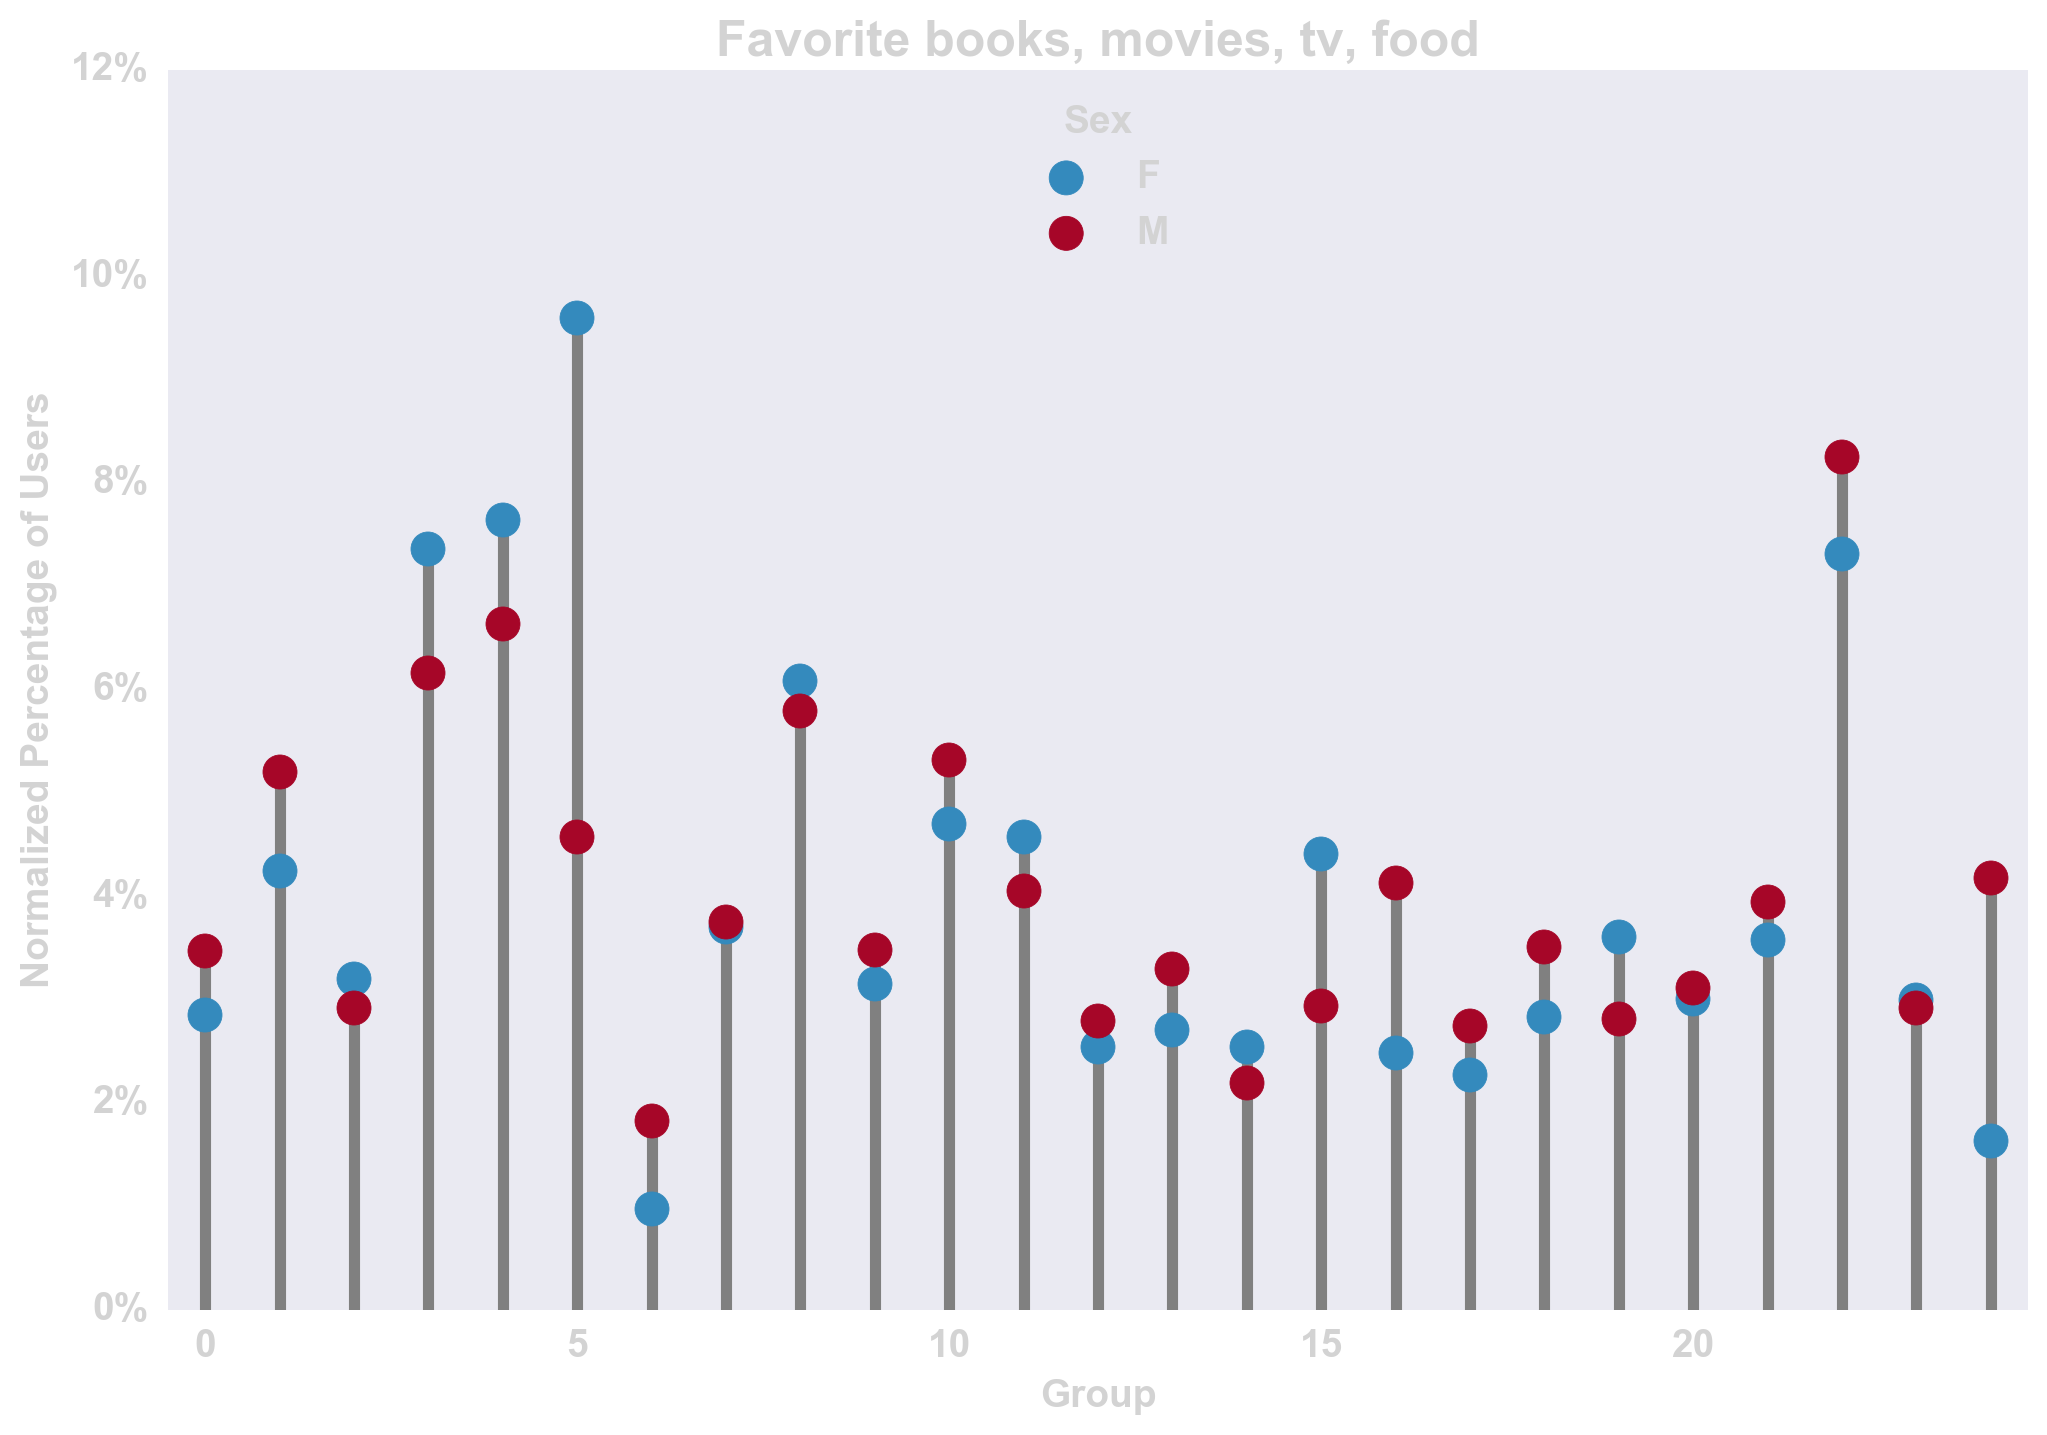

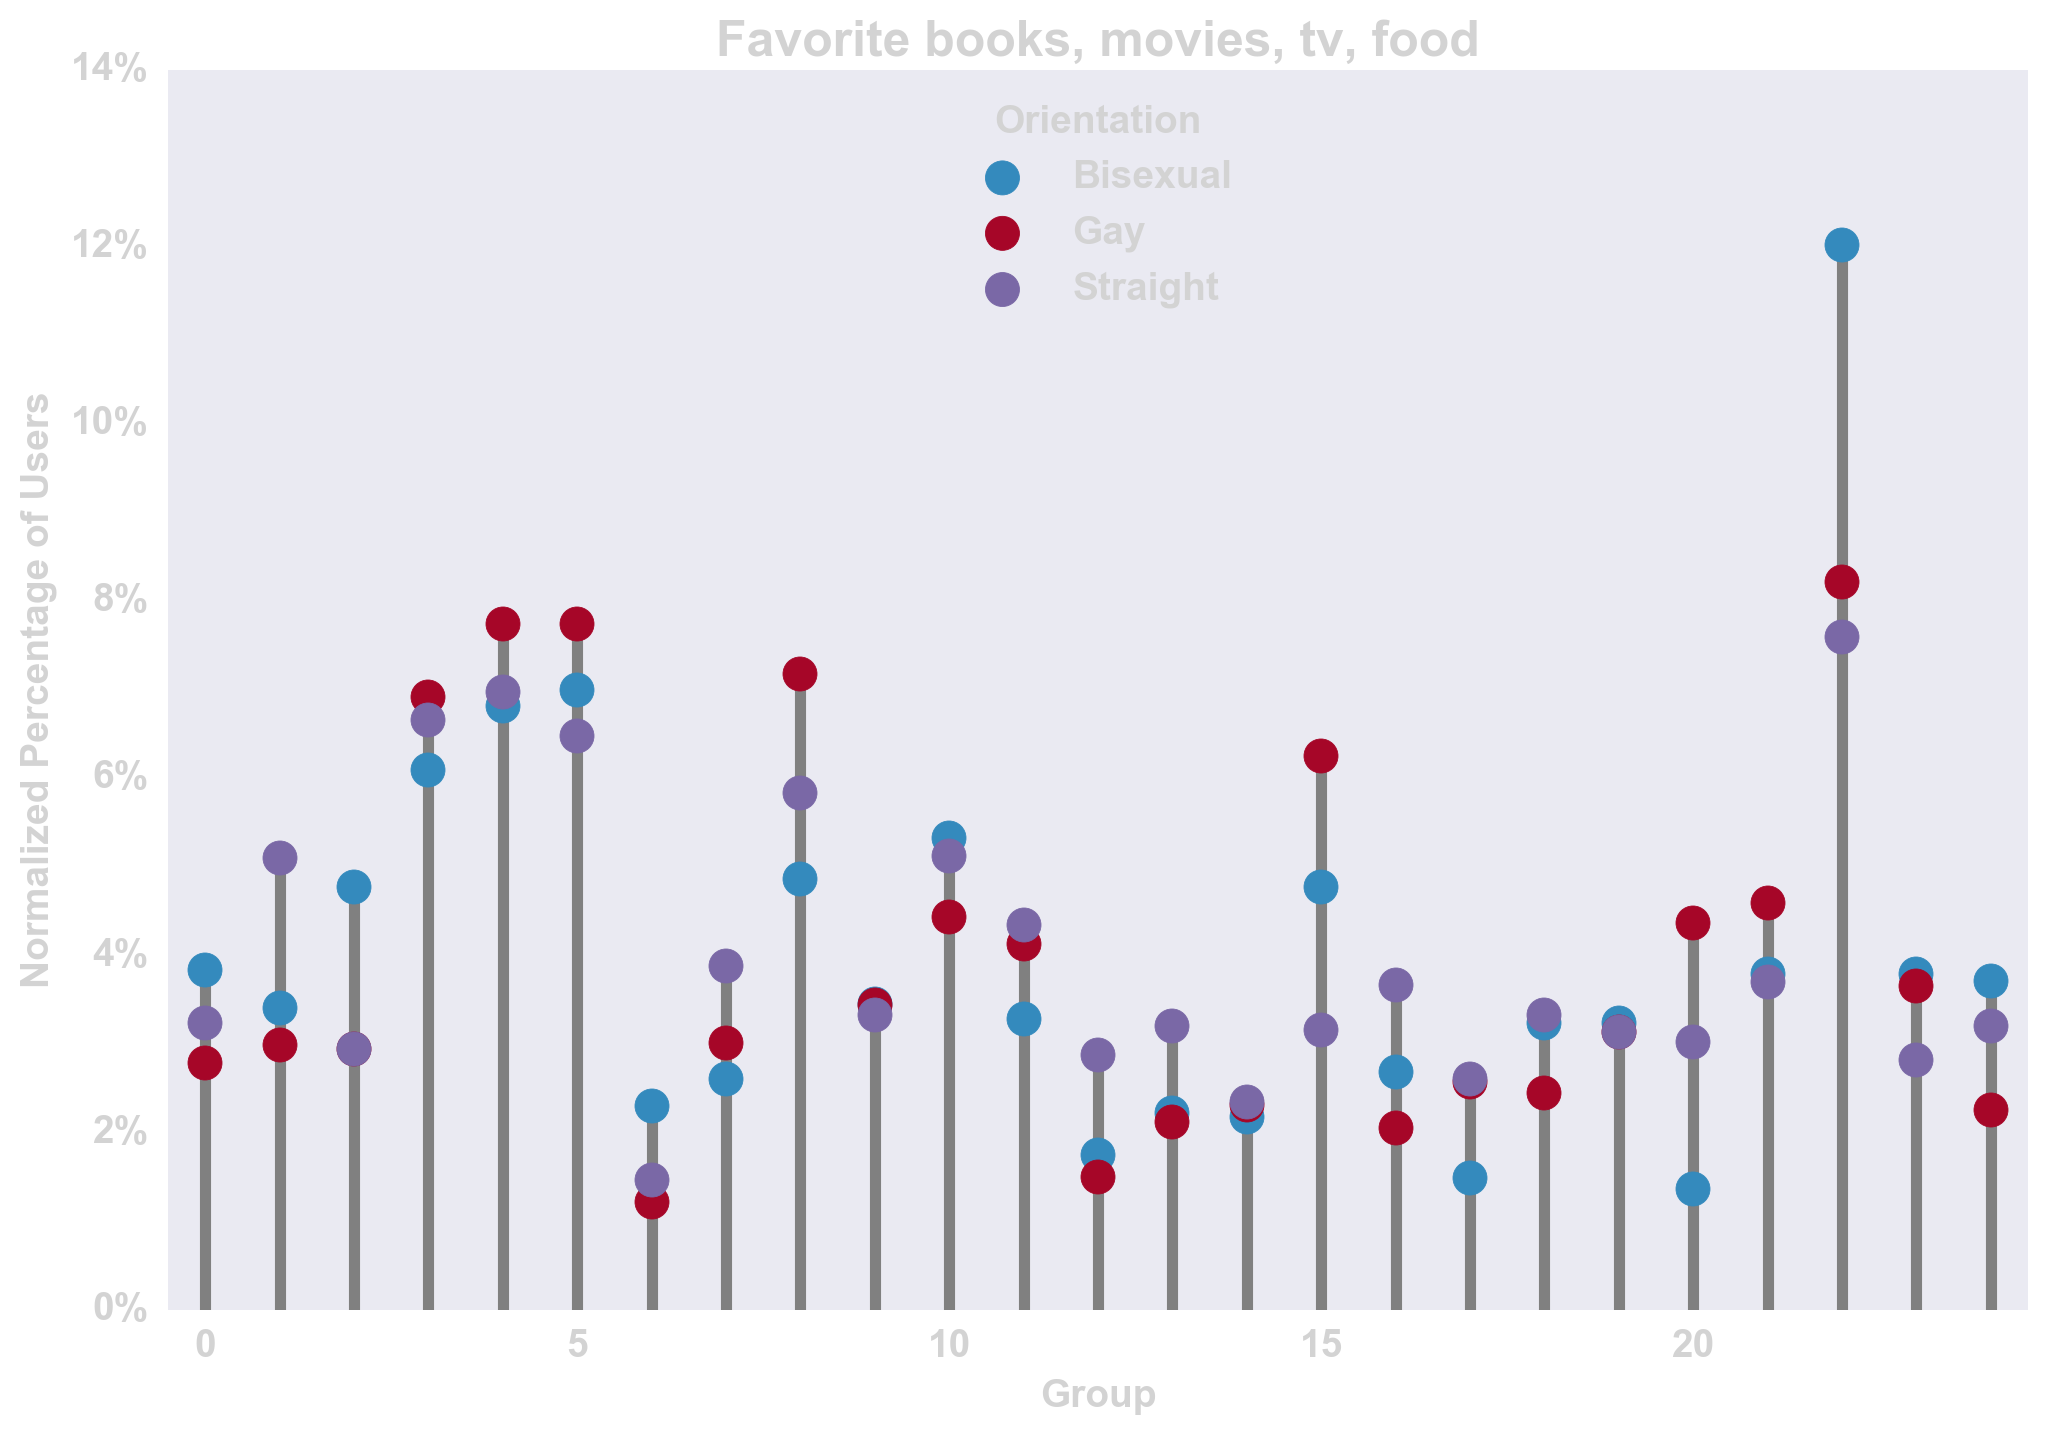

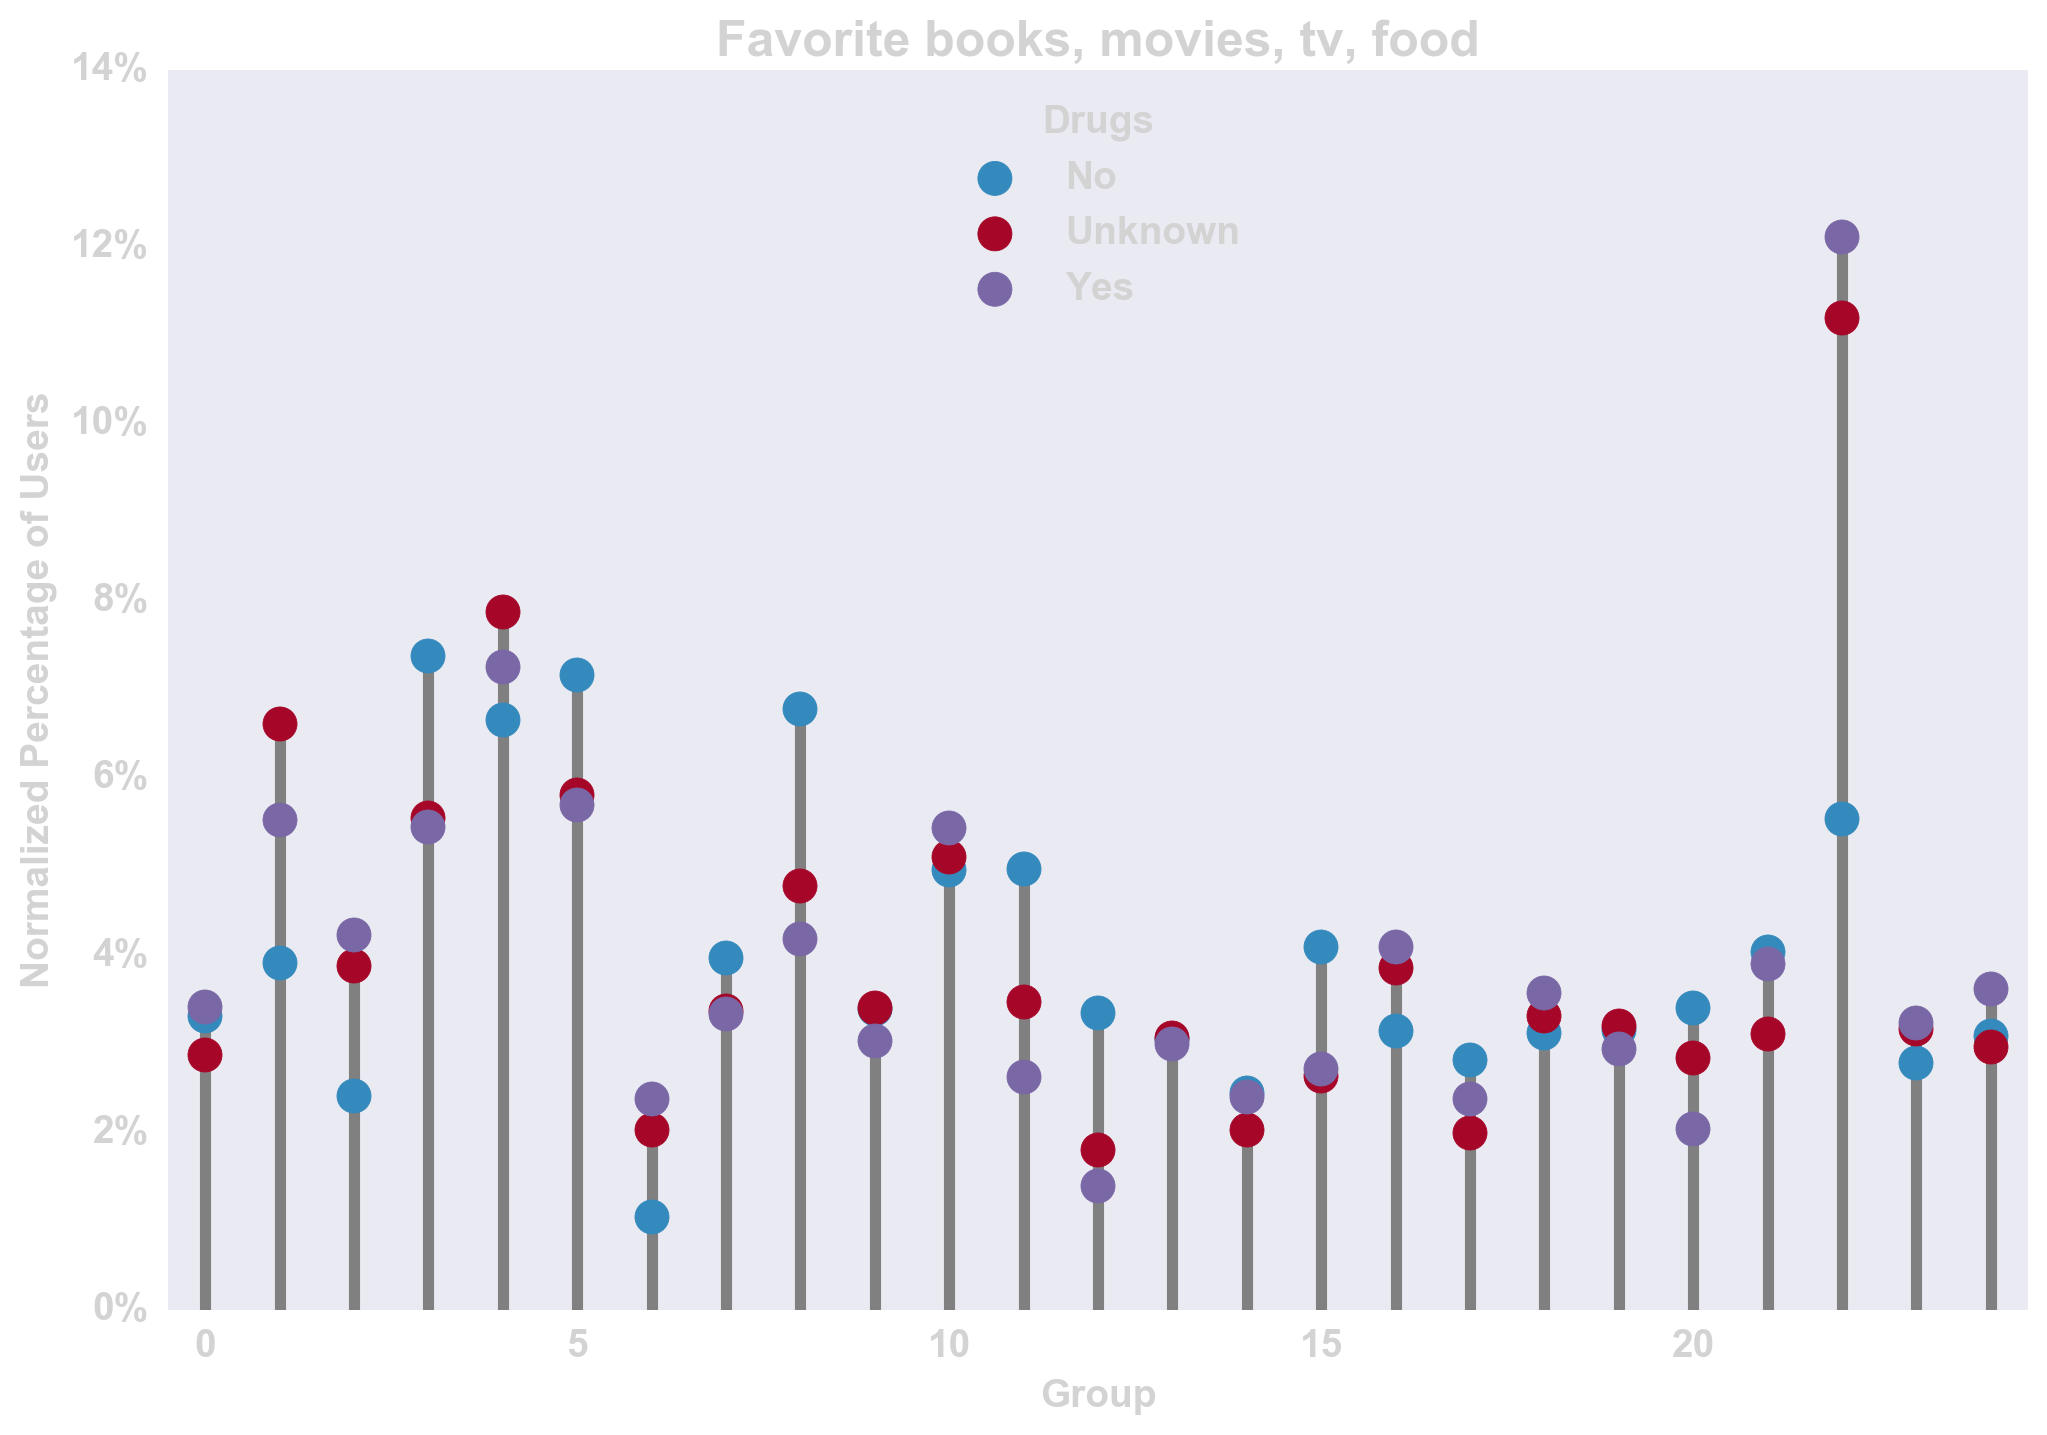

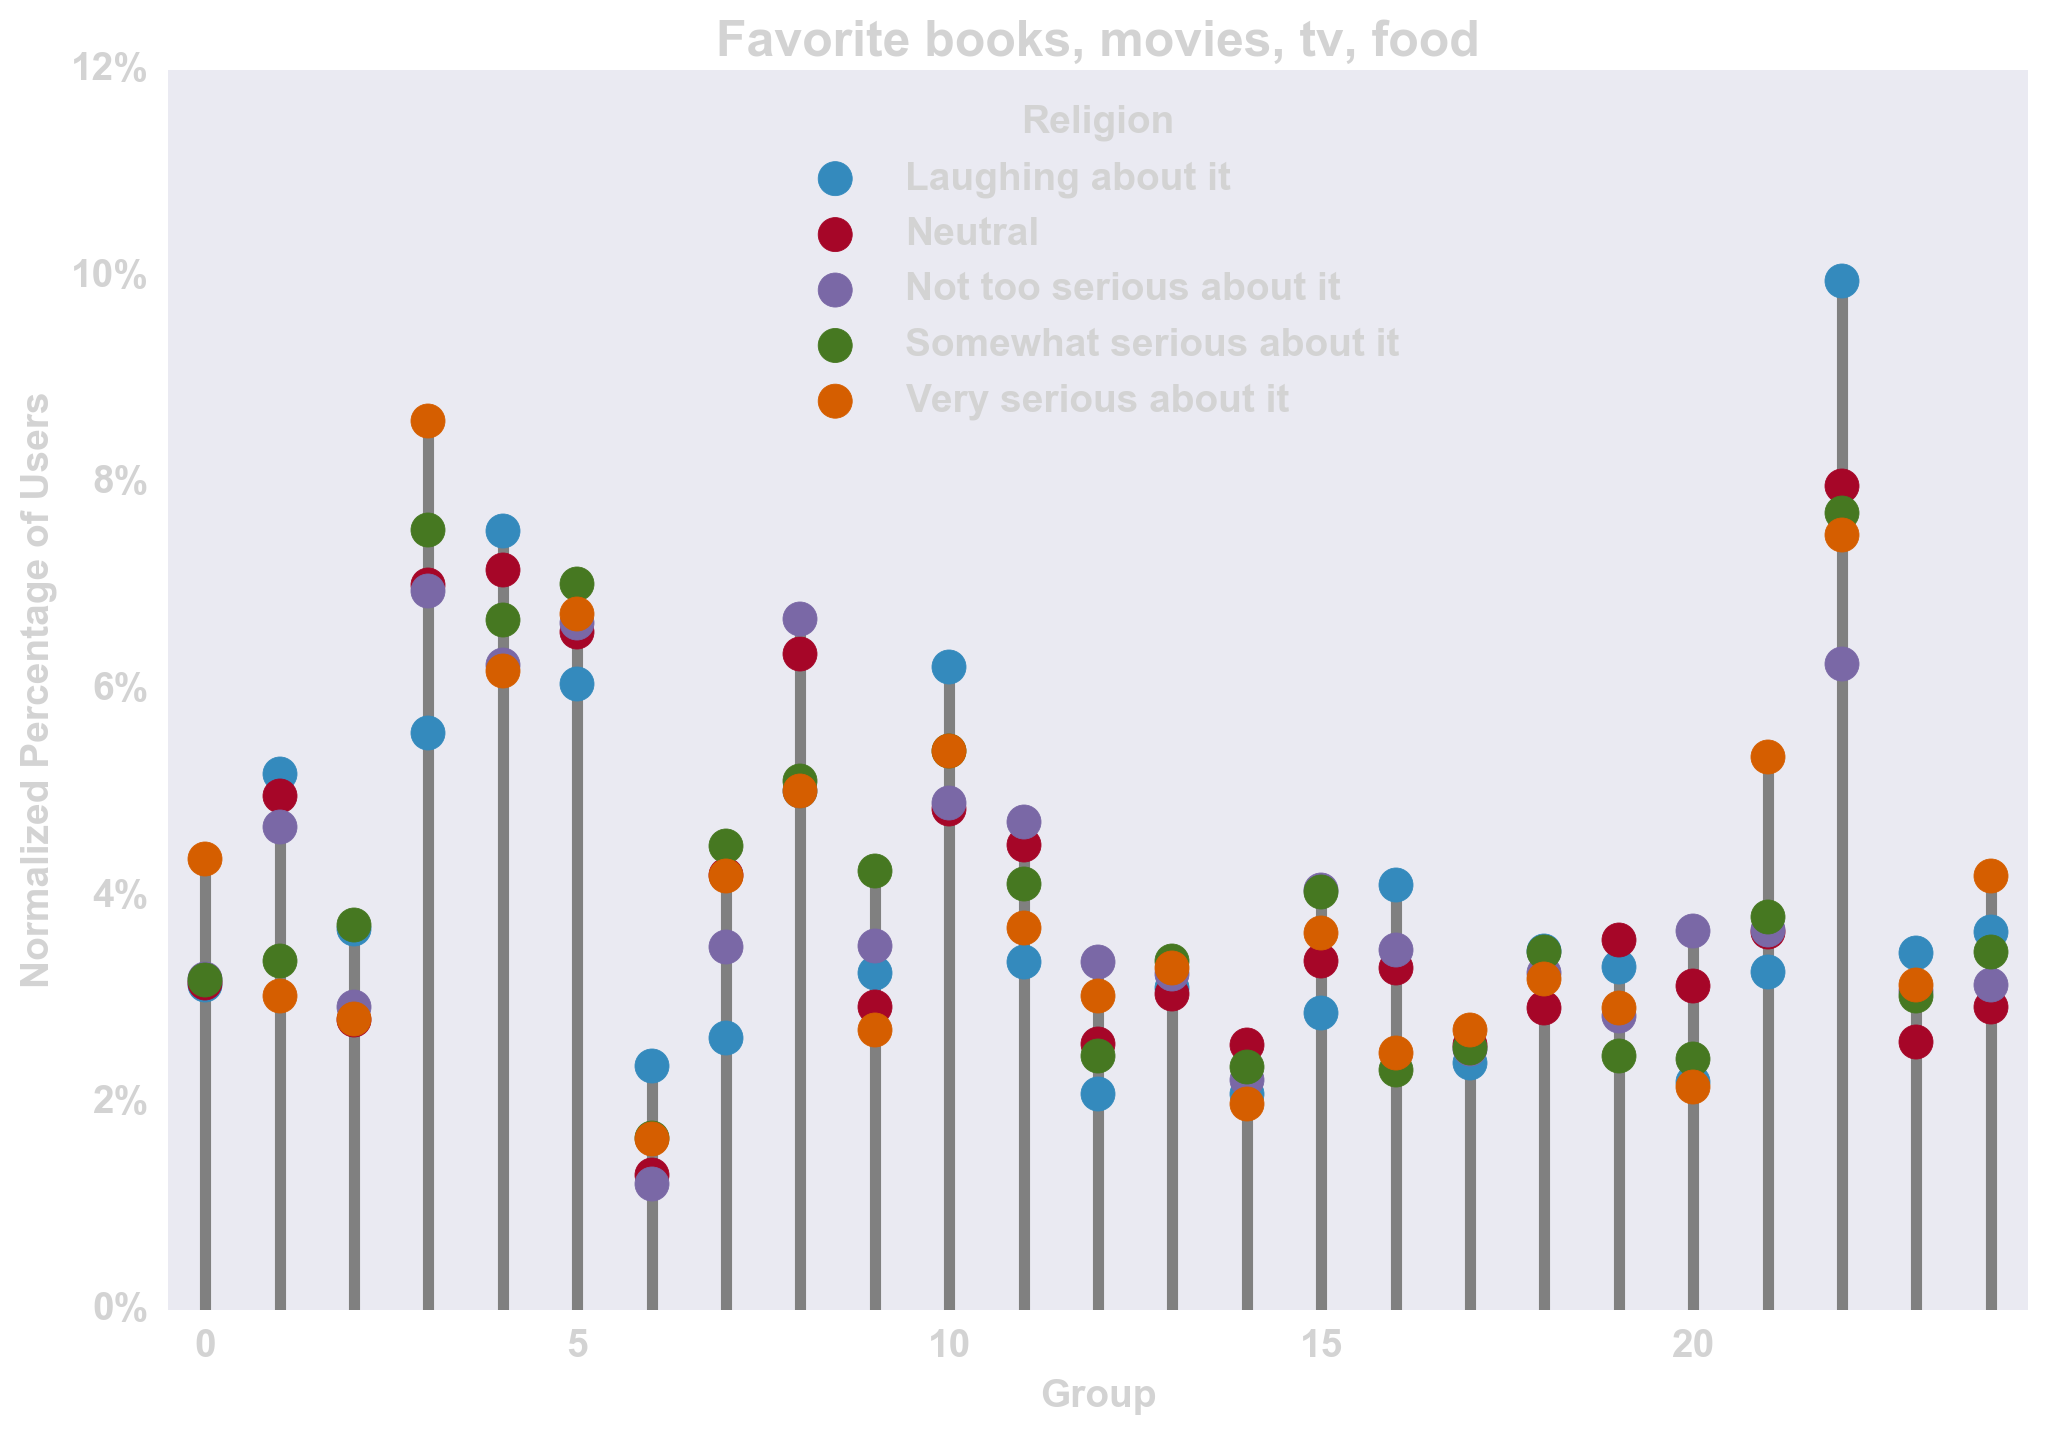

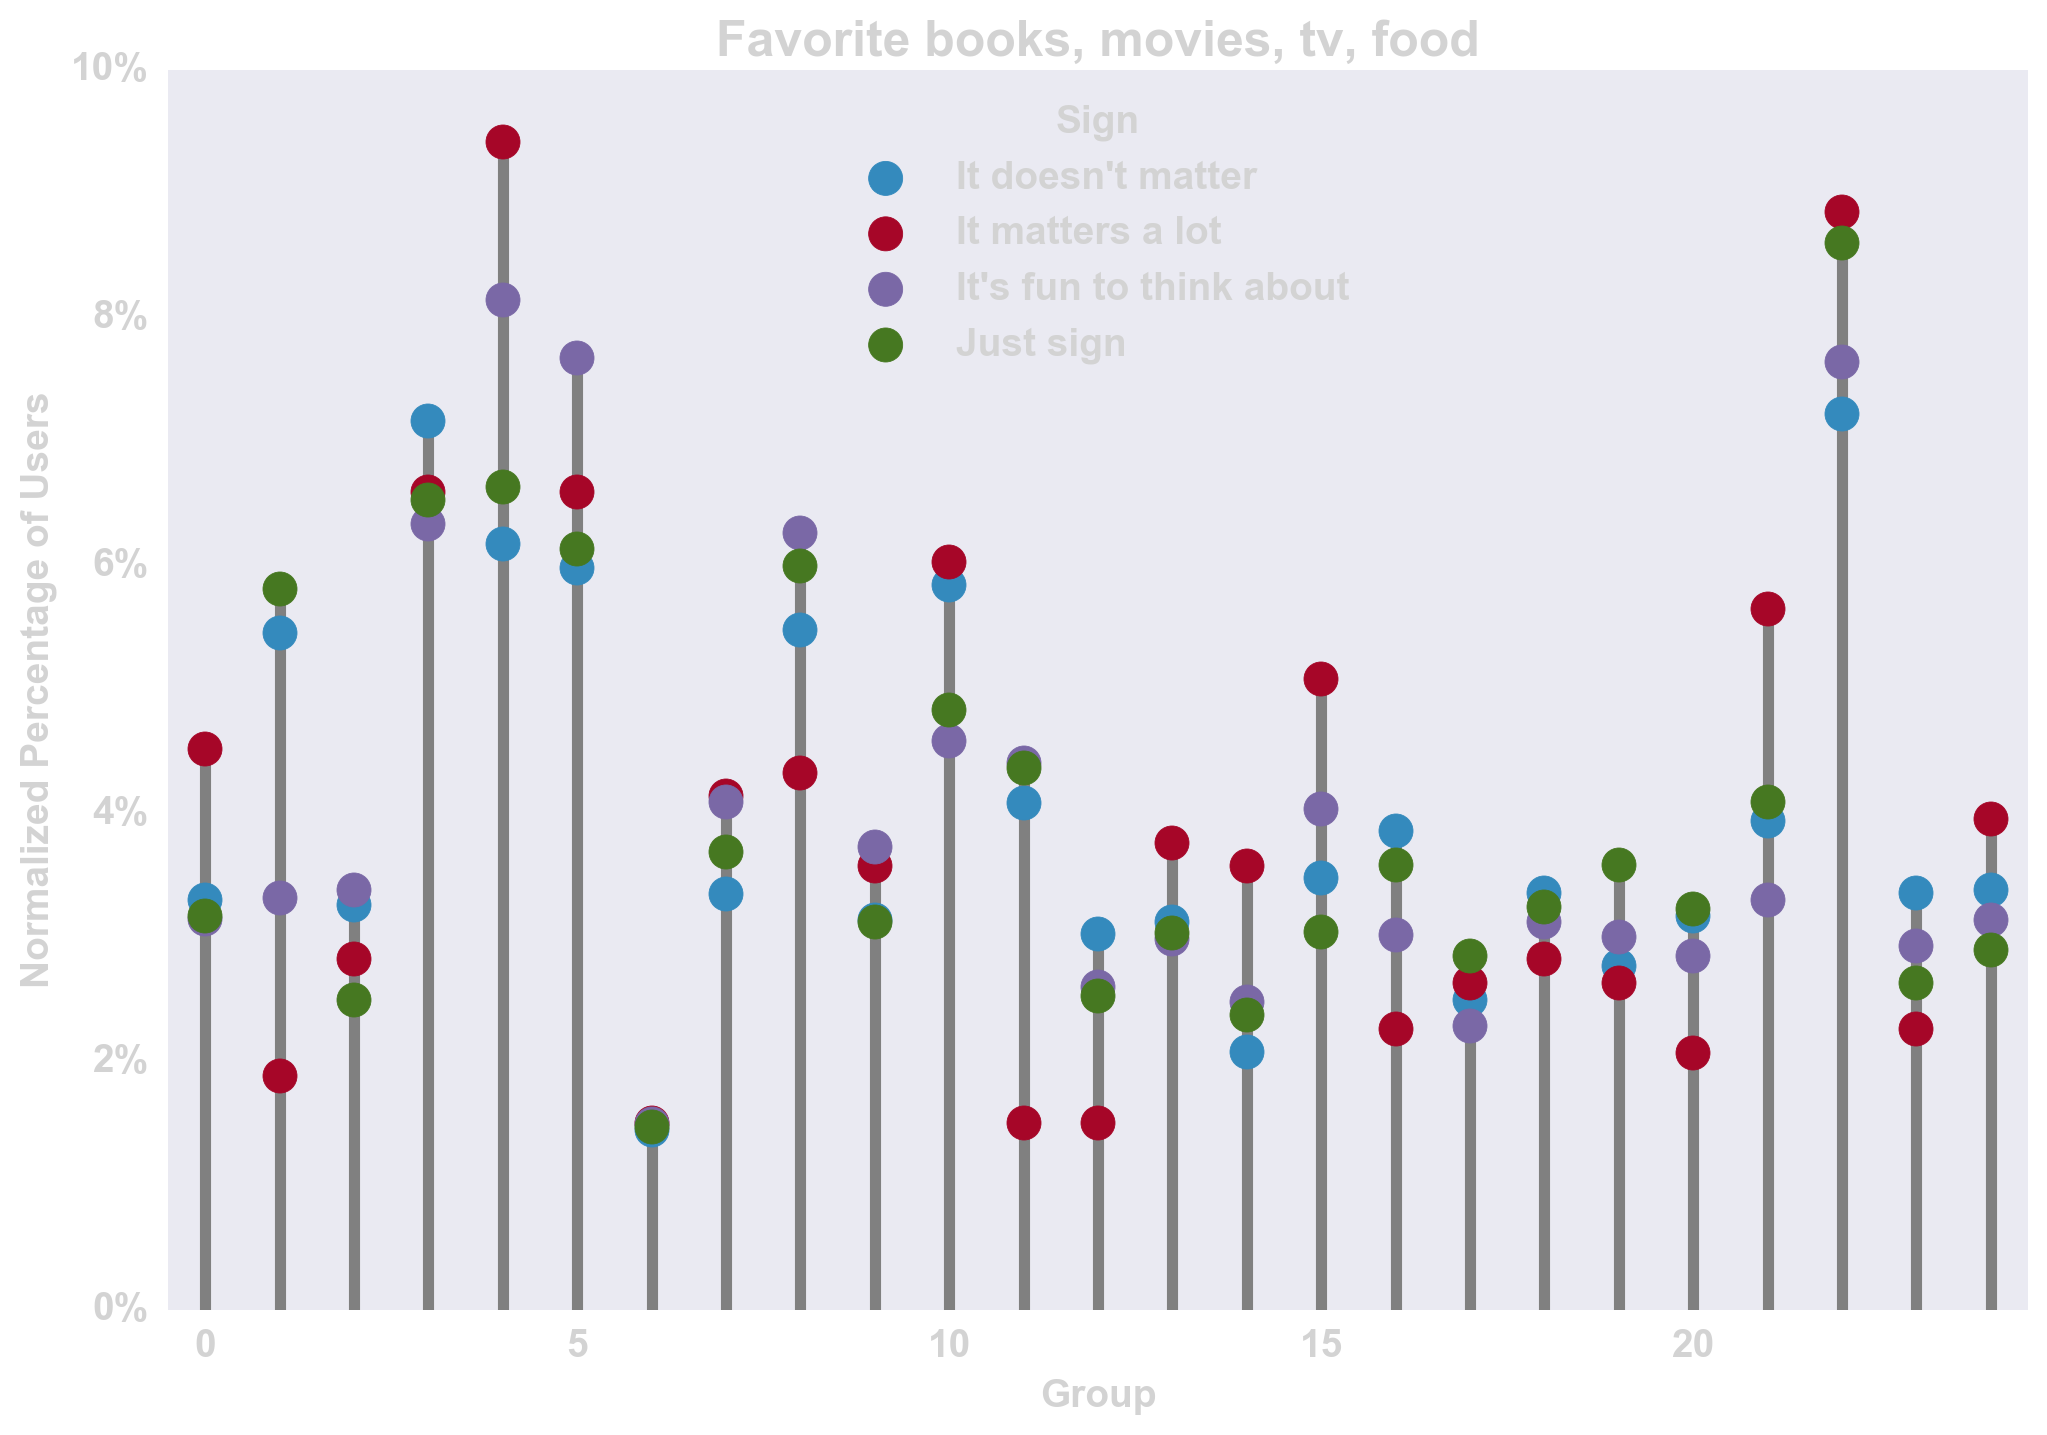

In [14]:
sns.set_style("dark")

filenames = ['data/essay4_sex.png', 'data/essay4_orientation.png',
             'data/essay4_drugs.png', 'data/essay4_religion.png',
             'data/essay4_sign.png']

for f, demog in enumerate(['sex', 'orientation', 'drugs', 'religion', 'sign']):
    this = pd.DataFrame({'count' :
                         df_clean.groupby([demog, 'group'])['group'].count()}).reset_index()
    that = this.groupby(demog, as_index=False)['count'].sum()
    this = pd.merge(this, that, on=demog)
    this['pct'] = this.count_x / this.count_y

    fig, ax = plt.subplots(figsize=(12, 8))
    
    # lines
    lineval = this.groupby('group')['pct'].max()
    for i, g in enumerate(lineval):
        plt.plot([i, i], [0, g],
                 linewidth=4,
                 color='gray',
                 zorder=1)

    # markers
    for i, d in enumerate(this[demog].unique()):
        tdf = this[this[demog]==d]
        plt.scatter(range(len(tdf)), tdf.pct,
                    s=150,
                    color=colors[i],
                    zorder=2, label=d.capitalize())
    
    plt.xlim(-0.5, len(tdf)-0.5)
    plt.ylim(0)
    
    plt.gca().get_yaxis().set_major_formatter(
                mpl.ticker.FuncFormatter(lambda y, p: format(y, '.0%'))
            )

    plt.xlabel('Group')
    plt.ylabel('Normalized Percentage of Users')

    plt.title(essay_dict[essay_list[0]], fontsize = 18, fontweight = 'bold', color = 'lightgray')
    lg = plt.legend(title=demog.title(), loc=9, fontsize = 14)
    for text in lg.get_texts():
        plt.setp(text, color = 'lightgray', weight = 'bold')
    lg.get_title().set_fontsize(14)
    lg.get_title().set_fontweight('bold')
    lg.get_title().set_color('lightgray')
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontweight('bold')
        label.set_fontsize(14)
        label.set_color('lightgray')
        
    ax.xaxis.label.set_color('lightgray')
    ax.xaxis.label.set_fontweight('bold')
    ax.xaxis.label.set_fontsize(14)
    
    ax.yaxis.label.set_color('lightgray')
    ax.yaxis.label.set_fontweight('bold')
    ax.yaxis.label.set_fontsize(14)
    
    plt.savefig(filenames[f], transparent=True)